In [1]:
import sys
print(sys.version)

3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


In [2]:
# This is a helper class to track computing time
import time
class Reporter(object):
    def __init__(self):
        self.ctime = time.time()
        self.stime = self.ctime
        self.ltime = self.ctime
        pass
    def report(self, string):
        self.ctime = time.time()
        print("dt: %.2f, total: %.2f -- %s" % (self.ctime - self.ltime, self.ctime - self.stime, string))
        self.ltime = self.ctime

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import pymc3 as pm
import numpy as np
import theano as th

# list of available distributions
# https://docs.pymc.io/api/distributions.html

In [4]:
# Start generating simulated data
# The TFs: Number of TF and activation state of each
NX = 7
X = dict(zip(list(range(NX)), [0]*NX))

# the target genes: Number of target genes and state of each
NY = 70
Y = dict(zip(list(range(NX,NX+NY)), [0]*NY))

In [5]:
# generate a random set of interations between TFs and genes
edges = {}
for trg in Y.keys():
    # randomize the number of TFs for this gene
    num_edges = np.random.binomial(3, 0.5)
    
    # pick random TFs
    for src in np.random.choice(list(X.keys()), size=num_edges, replace=False):
        # here an edge can be valid (1) or not valid (0)
        edges[(src, trg)] = np.random.choice([0, 1])
    

In [6]:
# A small visualization of the interactions between TFs and target genes
G = nx.DiGraph()
G.add_nodes_from(X.keys())
G.add_nodes_from(Y.keys())
G.add_edges_from(edges.keys())

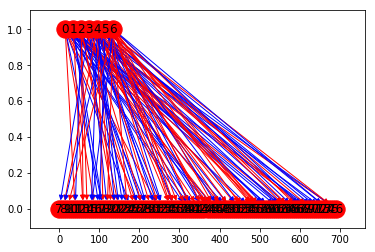

In [7]:
# a dictionary for mapping colors to signs
cdict = {-1: 'g',
         0: 'b',
         1: 'r'}

labels = {}
for node in G.nodes():
    G.nodes[node]['label'] = node
    labels[node] = node

for u,v in G.edges():
    G[u][v]['color'] = cdict[edges[(u,v)]]
colors = [G[u][v]['color'] for u,v in G.edges()]
    
pos = {}
for i, node in enumerate(X.keys()):
    pos[node] = [i*20+15, 1]
for i, node in enumerate(Y.keys()):
    pos[node] = [i*10, 0]

nx.draw_networkx_nodes(G, pos=pos, nodelist=X.keys())
nx.draw_networkx_nodes(G, pos=pos, nodelist=Y.keys())
nx.draw_networkx_edges(G, pos=pos, edge_color=colors)
nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=12)
plt.show()

<BarContainer object of 10 artists>

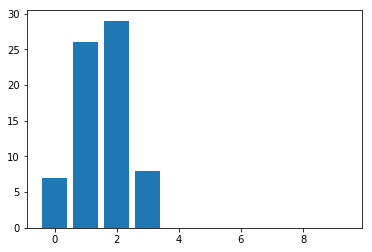

In [8]:
#list(G.predecessors(27))
h = nx.degree_histogram(G)[:10]
plt.bar(range(len(h)), h)

In [9]:
# randomize current activation state for TFs
# and then determine the state of targeted genes
for src in X.keys():
    # either active (1) or inactive (0)
    X[src] = np.random.choice([0, 1])
    if X[src] != 0:
        for trg in Y.keys():
            edge = src, trg
            if edge in edges.keys():
                if edges[edge] < 0 and X[src] > 0:
                    # if TF is inhibitor, make sure the response is definitive
                    Y[trg] += edges[edge]*X[src]*10000
                else:
                    Y[trg] += edges[edge]*X[src]
            

In [10]:
# Store this as the ground truth
Xgt = X
Xgt

{0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1}

In [11]:
#Y

In [12]:
# get only the signs for gene activation states
for trg in Y.keys():
    Y[trg] = np.sign(Y[trg])

In [13]:
#Y

In [14]:
# this is the possible associations data
rels = pd.DataFrame(list(edges.keys()), columns=['srcuid', 'trguid'])
rels = rels.assign(val=list(edges.values()))

In [15]:
# extract a dataframe that only contains relevant interactions
rels2 = rels[rels['trguid'].isin(Y.keys())]

# create several dictionaries for mapping uids to a range starting from zero
# this is for better performance by making a single function call
# to create the distributions in pymc3
xs = rels2['srcuid'].unique()
ys = Y.keys()
Dx = dict(zip(xs, range(len(xs))))
Dy = dict(zip(ys, range(len(ys))))

# this is the inverse of the dictionary
# it simply goes in the reverse direction
ADx = {}
for src, i in Dx.items():
    ADx[i] = src

Ds = {}
ADs = {}
for i, (index, row) in enumerate(rels2.iterrows()):
    src = row['srcuid']
    trg = row['trguid']
    Ds[(src, trg)] = i
    ADs[i] = src, trg

In [16]:
model = pm.Model()
reporter = Reporter()

with model:
    p = {}

    reporter.report('Start')

    # Unobserved states for TFs
    X = pm.Beta('X', shape=(len(Dx),), alpha=0.4, beta=0.4)
    reporter.report('Created TF state variables')

    # Unobserved state of edges (valid or invalid)
    S = pm.Beta('S', shape=(len(rels2),), alpha=0.4, beta=0.4)
    reporter.report('Created S state variables')
    
    # Wire up the logic
    T = {}
    for trg, j in Dy.items():
        T[j] = {}
        
    for (src, trg), k in Ds.items():
        i = Dx[src]
        j = Dy[trg]
        T[j][i] = th.tensor.minimum(X[i], S[k]) # X ^ S

    reporter.report('Completed gates for Ts')
    
    for trg, j in Dy.items():
        p[j] = 0.
        for i in T[j].keys():
            # OR gate for all TFs potentially affecting this gene
            p[j] = th.tensor.maximum(p[j], T[j][i])
    
    reporter.report('Completed gates for Ps')
    
    # need to convert dictionaries into lists
    pp, YY = [], []
    for trg, j in Dy.items():
        pp.append(p[j])
        YY.append(Y[trg])
        
    reporter.report('Rearranged Ps and Ysf or likelihood function')
    
    # the likelihood
    D = pm.Bernoulli('D', p=pp, observed=YY)
    reporter.report('Set observed distributions')
    

dt: 0.00, total: 0.00 -- Start
dt: 2.60, total: 2.60 -- Created TF state variables
dt: 0.34, total: 2.95 -- Created S state variables
dt: 0.19, total: 3.13 -- Completed gates for Ts
dt: 0.08, total: 3.21 -- Completed gates for Ps
dt: 0.00, total: 3.21 -- Rearranged Ps and Ysf or likelihood function
dt: 0.39, total: 3.60 -- Set observed distributions


In [17]:
reporter = Reporter()
reporter.report('Start')
with model:
    reporter.report('Model Initiated')
    # draw posterior samples
    trace = pm.sample(tune=500, draws=500, step=None, chains=3, njobs=3)
    reporter.report('Finished Sampling')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


dt: 0.00, total: 0.00 -- Start
dt: 0.00, total: 0.00 -- Model Initiated


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [S, X]
Sampling 3 chains: 100%|██████████| 3000/3000 [00:25<00:00, 119.83draws/s]
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


dt: 41.83, total: 41.83 -- Finished Sampling


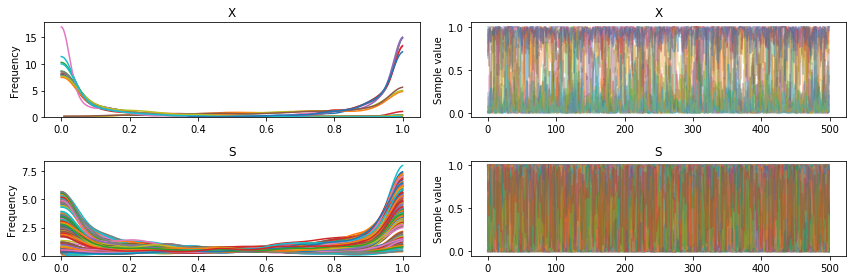

In [18]:
plots = pm.traceplot(trace)

In [19]:
result = pm.summary(trace)

In [20]:
ADx = {}
for src, i in Dx.items():
    ADx[i] = src

In [21]:
Xres = result.loc[['X__%d'%i for i in range(len(Dx))]]
Xres = Xres.assign(srcuid=[ADx[i] for i in range(len(Dx))])
Xres = Xres.assign(ground_truth=[Xgt[src] for src in Xres['srcuid']])
Xres = Xres.assign(prediction=Xres['mean'].round())
Xres = Xres.assign(correctness=Xres['ground_truth']==Xres['prediction'])
Xres = Xres.drop(columns=['mc_error', 'hpd_2.5', 'hpd_97.5', 'n_eff', 'Rhat'])

In [22]:
Xres

,mean,sd,srcuid,ground_truth,prediction,correctness
X__0,0.927916,0.090883,6,1,1.0,True
X__1,0.723880,0.259985,0,1,1.0,True
X__2,0.071908,0.117376,4,0,0.0,True
X__3,0.158397,0.239698,5,0,0.0,True
X__4,0.151069,0.208998,3,0,0.0,True
X__5,0.120182,0.190292,1,0,0.0,True
X__6,0.916354,0.100907,2,1,1.0,True


In [23]:
Xres['correctness'].value_counts(normalize=True)

True    1.0
Name: correctness, dtype: float64

In [24]:
Sres = result.loc[['S__%d'%i for i in range(len(Ds))]]
Sres = Sres.assign(edge=[ADs[i] for i in range(len(Ds))])
Sres = Sres.assign(ground_truth=[edges[edge] for edge in Sres['edge']])
Sres = Sres.assign(prediction=Sres['mean'].round())
Sres = Sres.assign(correctness=Sres['ground_truth']==Sres['prediction'])
Sres = Sres.drop(columns=['mc_error', 'hpd_2.5', 'hpd_97.5', 'n_eff', 'Rhat'])

In [25]:
Sacc = Sres['correctness'].value_counts(normalize=True)[True]
print("Edge prediction accuracy:", Sacc)

Edge prediction accuracy: 0.685185185185
